In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_excel("FOMC_token_separated.xlsx")
data = data.dropna()

# Use meeting-aggregation to perform LDA with TF-IDF cleanup

In [39]:
meeting_text = []
for meeting in data['Date'].unique():
    meeting_text.append(' '.join(data.groupby('Date').get_group(meeting)['content'].values).split(' '))

In [6]:
import gensim
from gensim import corpora, models

C:\Users\barry\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [230]:
dictionary = corpora.Dictionary(meeting_text)

In [231]:
corpus = [dictionary.doc2bow(text) for text in meeting_text]

In [232]:
tfidf = models.TfidfModel(corpus, id2word = dictionary)

Follow HMP, we define the TF-IDF score for each term $t$ as 

$$
\text{TF-IDF}_t = Tf_t \times Df_t
$$
where $$Tf_t = 1+\log{n_t} = 1 + \log{\sum_d n_{t,d}}$$, and $$IDF_t = \log(\frac{D}{D_t}) = \log(\frac{D}{\sum_d \mathbb{1}\{n_{t,d} >0\}})$$

where $n_{t,d}$ is the count of term $t$ in document $d$. Note that this calculation is applied for the entire document, meaning that each term gets one TF-IDF score, as oppose to common practice where TF-IDF is calculated differently for the same term in different document

In [62]:
#In gensim default practice, the tf-idf of the same term (0) in different documents are different
print(tfidf[corpus][0][0])
print(tfidf[corpus][1][0])

(0, 0.021594972031988697)
(2, 0.000953251169690239)


In [234]:
# calculate our own tfidf
# first, we can extract term-document matrix as 
term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary.keys()))
term_document.shape

(11498, 148)

In [235]:
# Calculate tf-idf
TF = 1+np.log(term_document.sum(axis = 1))
IDF = np.log(term_document.shape[1] / np.count_nonzero(term_document, axis = 1))

TF_IDF = pd.Series(dict(zip(dictionary.keys(), TF*IDF)))
TF_IDF

0        4.118433
1        0.952854
2        0.103438
3        1.225809
4        3.107286
5        5.193166
6        1.412798
7        9.029460
8        0.174359
9        0.311120
10       4.997212
11       4.812495
12       3.823686
13       0.167170
14       1.391438
15       0.700080
16       9.773803
17       8.853012
18       0.305847
19       1.173733
20       0.172576
21       0.062154
22       0.000000
23       0.306943
24       0.323903
25       0.168990
26       8.646760
27       0.000000
28       4.748622
29       1.370186
           ...   
11468    4.997212
11469    4.997212
11470    4.997212
11471    4.997212
11472    4.997212
11473    4.997212
11474    4.997212
11475    8.461016
11476    4.997212
11477    4.997212
11478    4.997212
11479    4.997212
11480    4.997212
11481    4.997212
11482    4.997212
11483    8.461016
11484    4.997212
11485    8.461016
11486    4.997212
11487    4.997212
11488    4.997212
11489    4.997212
11490    4.997212
11491    4.997212
11492    4

We keep the top 9000 terms with highest TF-IDF score

In [236]:
keys_to_use = TF_IDF.sort_values(ascending = False)[:9000].index.values

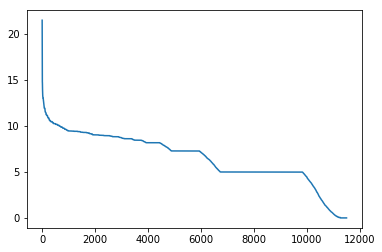

In [237]:
#We can plot the TF-IDF vs. the rank for each term
import matplotlib.pyplot as plt
TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
plt.show()

Now we generate the term-document matrix for only the top 9000 terms, and implement Online Learning LDA

In [238]:
dictionary.filter_tokens(good_ids = keys_to_use)
new_corpus = [dictionary.doc2bow(text) for text in meeting_text]

In [239]:
new_term_document = gensim.matutils.corpus2dense(new_corpus, num_terms=len(dictionary.keys()))
new_term_document.shape

(9000, 148)

In [155]:
ldamodel = models.ldamodel.LdaModel(new_corpus, num_topics=20, id2word = dictionary)

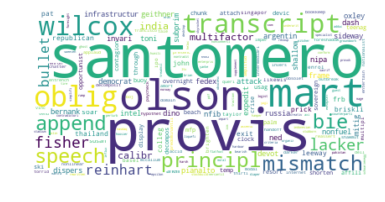

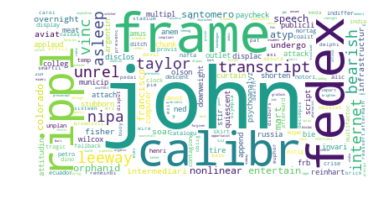

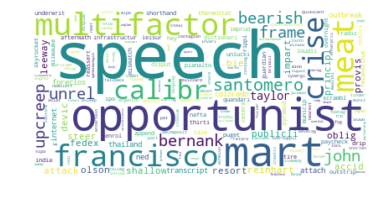

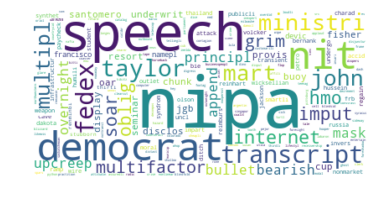

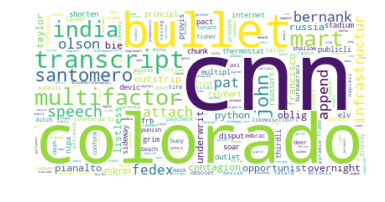

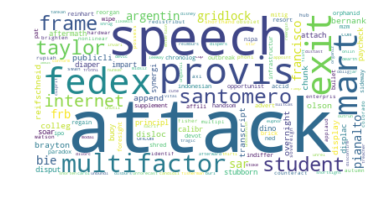

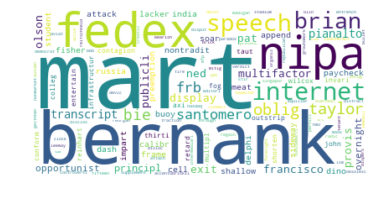

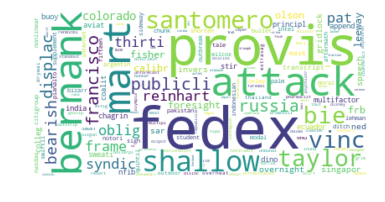

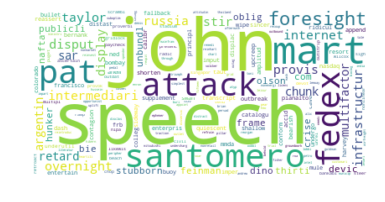

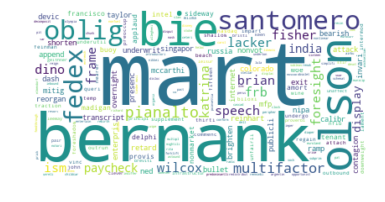

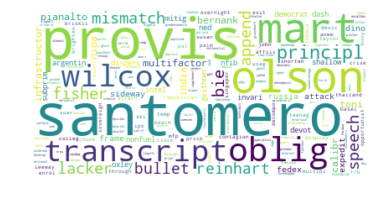

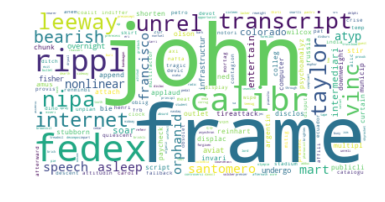

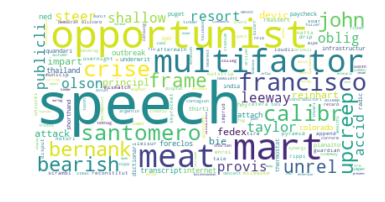

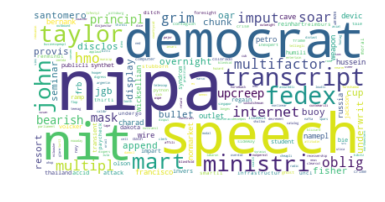

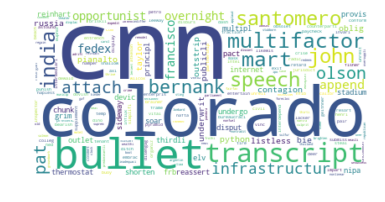

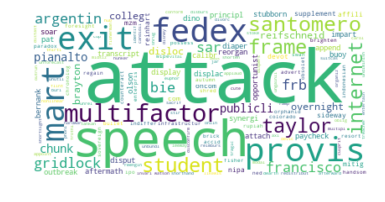

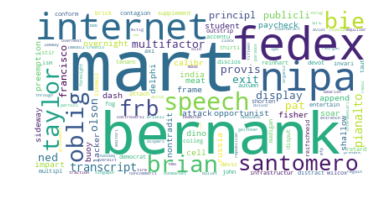

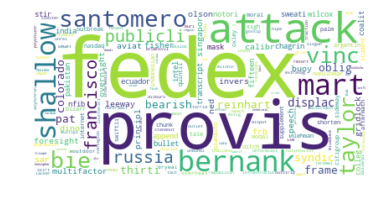

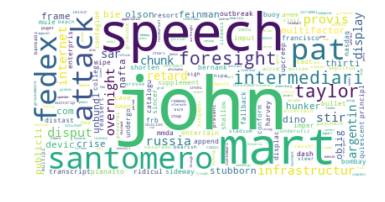

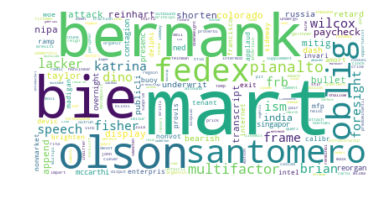

In [157]:
from wordcloud import WordCloud

for t in range(10):

    plt.figure()
    
    plt.imshow(WordCloud(background_color='white').fit_words(dict(ldamodel.show_topic(t,200))),interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()

# Using individual interjection to perform LDA with tf-idf cleanup

In [3]:
texts = []
for line in data['content'].values:
    texts.append(line.split(' '))

In [8]:
len(dictionary2.token2id)

11498

In [7]:
dictionary2 = corpora.Dictionary(texts)
corpus2 = [dictionary2.doc2bow(text) for text in texts]
len(corpus2)

26092

In [195]:
term_document2 = gensim.matutils.corpus2dense(corpus2, num_terms=len(dictionary2.keys()))

In [197]:
# Calculate tf-idf
TF2 = 1+np.log(term_document2.sum(axis = 1))
IDF2 = np.log(term_document2.shape[1] / np.count_nonzero(term_document2, axis = 1))

TF_IDF2 = pd.Series(dict(zip(dictionary2.keys(), TF2*IDF2)))
TF_IDF2

0        31.421449
1        26.082443
2        17.576262
3        29.925736
4        20.750603
5        30.483090
6        25.702556
7        20.198437
8        23.406191
9        24.760600
10       22.825024
11       19.644056
12       23.171383
13       31.022650
14       19.383414
15       21.847938
16       24.360314
17       23.587844
18       22.770758
19       19.575499
20       22.606186
21       25.609856
22       26.628729
23       25.891626
24       13.735104
25       26.859808
26       24.055064
27       30.883670
28       18.815171
29       24.459664
           ...    
11468    17.218264
11469    10.169384
11470    10.169384
11471    10.169384
11472    10.169384
11473    10.169384
11474    10.169384
11475    10.169384
11476    17.218264
11477    10.169384
11478    17.218264
11479    10.169384
11480    10.169384
11481    10.169384
11482    10.169384
11483    10.169384
11484    10.169384
11485    10.169384
11486    10.169384
11487    10.169384
11488    10.169384
11489    10.

In [219]:
#keep the top 6000 terms
keys_to_use2 = TF_IDF2.sort_values(ascending = False)[:6000].index.values

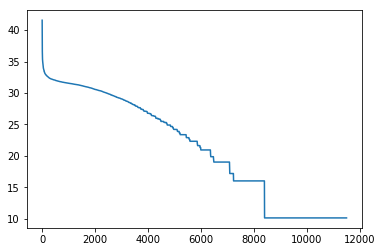

In [220]:
#We can plot the TF-IDF vs. the rank for each term
# Replicating Figure 1 in HMP paper
import matplotlib.pyplot as plt
TF_IDF2.sort_values(ascending = False).reset_index()[0].plot()
plt.show()

In [221]:
dictionary2.filter_tokens(good_ids = keys_to_use2)
new_corpus2 = [dictionary2.doc2bow(text) for text in texts]


In [222]:
new_term_document2 = gensim.matutils.corpus2dense(new_corpus2, num_terms=len(dictionary2.keys()))

In [223]:
new_term_document2.shape

(5319, 26092)

In [224]:
ldamodel2 = models.ldamodel.LdaModel(new_corpus2, num_topics=40, id2word = dictionary2)

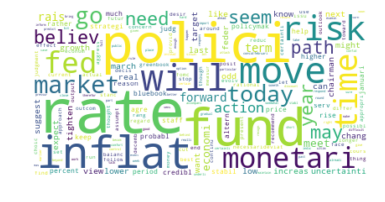

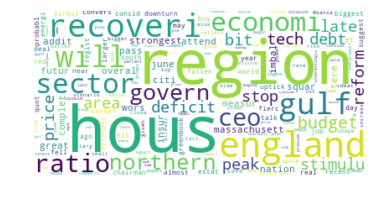

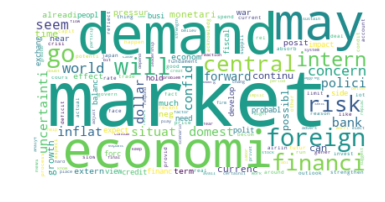

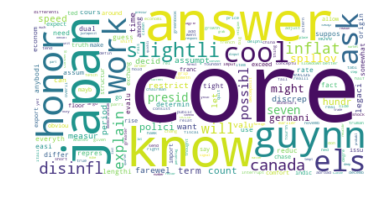

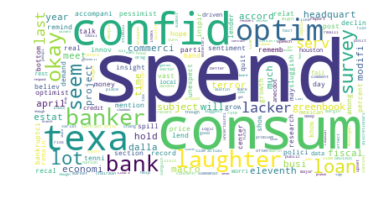

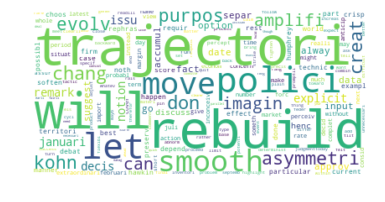

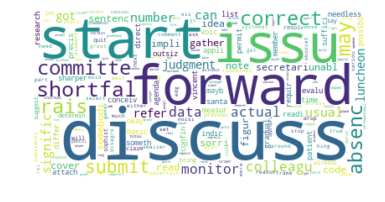

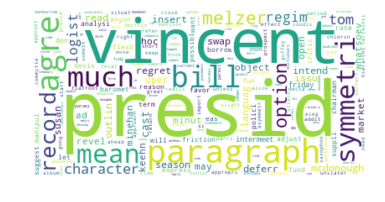

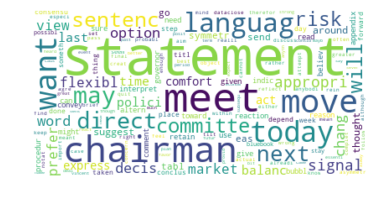

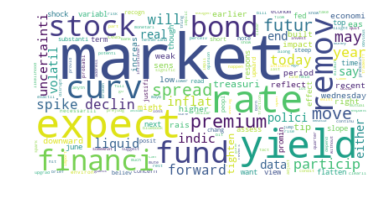

In [225]:
from wordcloud import WordCloud

for t in range(10):

    plt.figure()
    
    plt.imshow(WordCloud(background_color='white').fit_words(dict(ldamodel2.show_topic(t,200))),interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()

export term document matrices

In [242]:
pd.DataFrame(term_document).to_csv('Matrix_meeting.csv')
pd.DataFrame(new_term_document).to_csv('Matrix_meeting_tfidf.csv')
pd.DataFrame(term_document2).to_csv('Matrix_interjection.csv')
pd.DataFrame(new_term_document2).to_csv('Matrix_interjection_tfidf.csv')